# Titanic Data Analysis

# 準備

## 必要なライブラリをインポート

In [240]:
import lightgbm as lgb
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder

## 関数の定義

In [ ]:
class analyzer:
    def __init__(self, train_csv_file, test_csv_file, sep=",", engine="python"):
        self.train_df = pd.read_csv(train_csv_file, sep=sep, engine=engine)
        self.test_df = pd.read_csv(test_csv_file, sep=sep, engine=engine)
        self.fill_pattern = "None"  # 欠損値の補完方法を指定("None", "mean", "median", "mode", "0")
        self.features=["Age", "Fare", "Pclass","Sex_le"]# データセットに使用する特徴量を指定
        self.check_outliers_features = ["Age", "Fare"]
        self.feature_id="PassengerId"
        self.target="Survived"

    def get_information(self):
        print(self.train_df.info())
        print(self.train_df.describe().T)
        print("先頭の5行を表示")
        print(self.train_df.head())
        print(f"train dataframeの形状を確認:{self.train_df.shape}")
        print(f"test dataframeの形状を確認:{self.test_df.shape}")
        print(f"indexの確認;{self.train_df.index}")  # 表の縦軸
        print(f"カラムの確認:{self.train_df.columns}")  # 表の横軸
        print(f"欠損値の確認:\n{self.train_df.isnull().sum()}")
        print(f"運賃の平均値を確認:{self.train_df['Fare'].agg(['mean'])}")
        print(f"運賃に関する統計量を確認:\n{self.train_df['Fare'].agg(['mean', 'std', 'min', 'max'])}")
        print(f"男女の人数を確認:{self.train_df['Sex'].value_counts()}")
        # print("trainデータの観察:")
        # profile = ProfileReport(self.train_df)
        # display(profile)

    def make_dataset(self):
        x_train = self.train_df[self.features]
        y_train = self.train_df[self.target] if self.target else None
        id_train = self.train_df[self.feature_id] if self.feature_id else None
        print(f"x_train: {x_train.shape}, y_train: {y_train.shape if y_train is not None else None}, id_train: {id_train.shape if id_train is not None else None}")
        return x_train, y_train, id_train

    def fill_missing_values(self):
        if self.fill_pattern=="None":
            self.train_df["Age_fill"]=self.train_df["Age"]
            self.test_df["Age_fill"]=self.test_df["Age"]
            print("欠損値補完を行いませんでした")
        elif self.fill_pattern == "mean":
            self.train_df["Age_fill"] = self.train_df["Age"].fillna(self.train_df["Age"].mean())
            self.test_df["Age_fill"] = self.test_df["Age"].fillna(self.test_df["Age"].mean())
            print("欠損値を平均値で補完しました")
        elif self.fill_pattern == "median":
            self.train_df["Age_fill"] = self.train_df["Age"].fillna(self.train_df["Age"].median())
            self.test_df["Age_fill"] = self.test_df["Age"].fillna(self.test_df["Age"].median())
            print("欠損値を中央値で補完しました")
        elif self.fill_pattern == "mode":
            self.train_df["Age_fill"] = self.train_df["Age"].fillna(self.train_df["Age"].mode()[0])
            self.test_df["Age_fill"] = self.test_df["Age"].fillna(self.test_df["Age"].mode()[0])
            print("欠損値を最頻値で補完しました")
        elif self.fill_pattern == "0":
            self.train_df["Age_fill"] = self.train_df["Age"].fillna(0)
            self.test_df["Age_fill"] = self.test_df["Age"].fillna(0)
            print("欠損値を0で補完しました")
        else:
            print("Unknown fill_pattern. Please use 'mean', 'median', 'mode', or '0'.")
    
    def create_missing_flags(self, feature="Age"):
        self.train_df[f"{feature}_missing"] = self.train_df[feature].isnull()*1# isnull=1, notnull=0
        self.test_df[f"{feature}_missing"] = self.test_df[feature].isnull()*1
        result=self.train_df[[feature, f"{feature}_missing"]].head(7)
        display(result)
    
    def label_encode(self, feature):
        le=LabelEncoder()
        le.fit(self.train_df[f"{feature}"])
        self.train_df[f"{feature}_le"]=le.transform(self.train_df[f"{feature}"])
        self.test_df[f"{feature}_le"]=le.transform(self.test_df[f"{feature}"])
        result=self.train_df[[f"{feature}", f"{feature}_le"]].head(5)
        display(result)

    def create_combined_features(self, feature1=None, feature2=None):
        self.train_df[f"{feature1}+{feature2}"]=self.train_df[feature1]+self.train_df[feature2]
        self.test_df[f"{feature1}+{feature2}"]=self.test_df[feature1]+self.test_df[feature2]
        result=self.train_df[[feature1,feature2,f"{feature1}+{feature2}"]]
        print(f"{feature1}と{feature2}を合わせた新たな特徴量"f"{feature1}+{feature2}を作成しました")
        display(result)
        

    def check_outliers_min_max(self):
        for feature in self.check_outliers_features:
            if feature not in self.train_df.columns:
                print(f"Column '{feature}' does not exist in the DataFrame.")
                continue

            print(f"Outlier check for feature '{feature}':")

        result=self.train_df[self.check_outliers_features].agg(["min", "max"])
        display(result)

    def check_outliers_hist(self):
        for feature in self.check_outliers_features:
            if feature not in self.train_df.columns:
                print(f"Column '{feature}' does not exist in the DataFrame.")
                continue

            print(f"Outlier check for feature '{feature}':")

        result=self.train_df[self.check_outliers_features].hist(bins=40)
        plt.show()

    def split_train_val(self, x_train, y_train, test_size=0.2, shuffle=True, stratify=None, random_state=0):
        x_tr, x_va, y_tr, y_vr = train_test_split(x_train, y_train, test_size=test_size, shuffle=shuffle, stratify=stratify, random_state=random_state)
        print(f"x_tr: {x_tr.shape}, x_va: {x_va.shape}, y_tr: {y_tr.shape}, y_vr: {y_vr.shape}")
        return x_tr, x_va, y_tr, y_vr

    def display_confusion_matrix(self, y_val=None, x_val_pred=None):
        # 混同行列の作成
        cm = confusion_matrix(y_val, x_val_pred)
        # Confusion matrixの表示
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Reds)

        # X軸ラベル、Y軸ラベル、タイトルの追加
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')

        # Confusion matrixの表示
        plt.show()

    def display_prediction(self, y_val=None, x_val=None, model=None):
        if y_val is None or x_val is None or model is None:
            print("y_val or x_val or model is None")
            return

        y_val_pred = model.predict_proba(x_val)[:, 1]
        # 確率値をヒストグラムで表示
        fig = plt.figure(figsize=(10, 8))
        # 検証データ
        plt.title("Validation data")
        plt.hist(y_val_pred[y_val==1], bins=10, alpha=0.5, label="1")
        plt.hist(y_val_pred[y_val==0], bins=10, alpha=0.5, label="0")
        plt.grid()
        plt.legend()
        plt.show()

    def make_test_dataset(self):
        x_test = self.test_df[self.features]
        id_test = self.test_df[self.feature_id]
        print(f"x_test: {x_test.shape}, id_test: {id_test.shape}")
        return x_test, id_test

    def make_submission_file(self,y_test_pred=None, passenger_ids=None):
        df_submit=pd.DataFrame({"PassengerID": passenger_ids, "Survived": y_test_pred})
        display(df_submit.head())
        if os.path.exists("data") is False:
            os.makedirs("data")
        df_submit.to_csv("data/submission.csv", index=False)

## データ表示

In [242]:
a=analyzer("data/train.csv", "data/test.csv")
a.get_information()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
             count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pc

## データセットの作成

### 欠損値の補完

In [243]:
a.fill_missing_values()

欠損値補完を行いませんでした


### 特徴量の生成

In [244]:
a.create_missing_flags(feature="Cabin")
a.label_encode("Sex")
a.create_combined_features(feature1="SibSp", feature2="Parch")

,Cabin,Cabin_missing
0,NaN,1
1,C85,0
2,NaN,1
3,C123,0
4,NaN,1
5,NaN,1
6,E46,0


,Sex,Sex_le
0,male,1
1,female,0
2,female,0
3,female,0
4,male,1


SibSpとParchを合わせた新たな特徴量SibSp+Parchを作成しました


,SibSp,Parch,SibSp+Parch
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0
...,...,...,...
886,0,0,0
887,0,0,0
888,1,2,3
889,0,0,0


### Survivedと特徴量の関係を可視化

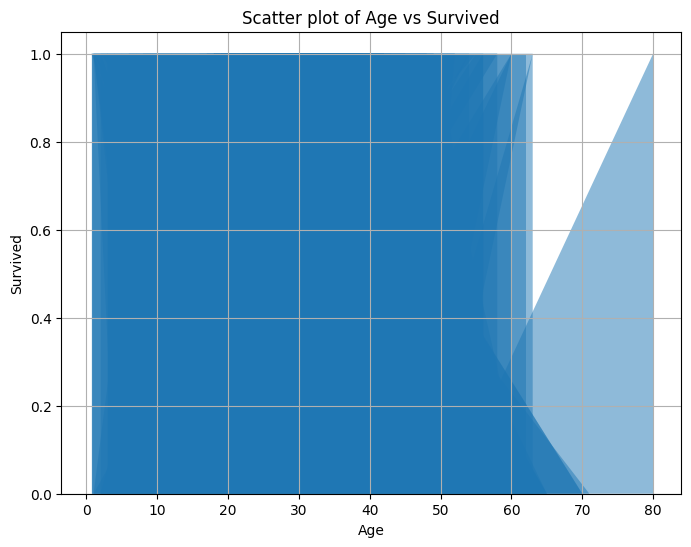

In [246]:
x_train, y_train, id_train = a.make_dataset()
# train,valに分割
x_train, x_val, y_train, y_val = a.split_train_val(x_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=12)

x_train: (891, 4), y_train: (891,), id_train: (891,)
x_tr: (712, 4), x_va: (179, 4), y_tr: (712,), y_vr: (179,)


### 外れ値の検出

Outlier check for feature 'Age':
Outlier check for feature 'Fare':


,Age,Fare
min,0.42,0.0000
max,80.00,512.3292


Outlier check for feature 'Age':
Outlier check for feature 'Fare':


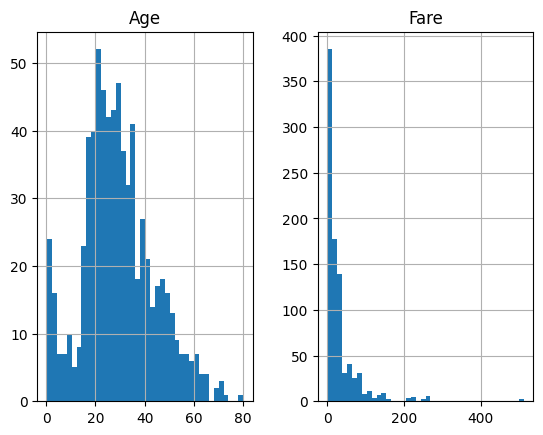

In [247]:
a.check_outliers_min_max()
a.check_outliers_hist()

# モデルの学習と評価

In [248]:
# ハイパーパラメータ設定
params = {
    "boosting_type": "gbdt",         # 勾配ブースティング決定木
    "objective": "binary",           # 2値分類
    "metric": "auc",                 # 評価指標はAUC
    "learning_rate": 0.1,            # 学習率
    "num_leaves": 16,                # 葉の数
    "n_estimators": 100000,          # 最大イテレーション数
    "random_state": 0,             # 乱数シード
    "importance_type": "gain"        # 特徴量重要度の計算方法
}

# モデルのインスタンス化
model = lgb.LGBMClassifier(**params)

# モデルの学習
model.fit(
    x_train, y_train,                                # 学習データ
    eval_set=[(x_train, y_train), (x_val, y_val)],   # 評価用データ（学習・検証）
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),     # 100回改善しなければ早期終了
        lgb.log_evaluation(period=10)                # 10回ごとに評価指標を表示
    ]
)

x_train_pred = model.predict(x_train)
x_val_pred = model.predict(x_val)
accuracy_train = accuracy_score(y_train, x_train_pred)
accuracy_val = accuracy_score(y_val, x_val_pred)

print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Validation Accuracy: {accuracy_val:.4f}")

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.912935	valid_1's auc: 0.851976
[20]	training's auc: 0.924475	valid_1's auc: 0.857312
[30]	training's auc: 0.934145	valid_1's auc: 0.862121
[40]	training's auc: 0.946298	valid_1's auc: 0.857773
[50]	training's auc: 0.955368	valid_1's auc: 0.85751
[60]	training's auc: 0.962198	valid_1's auc: 0.85448
[70]	training's auc: 0.968093	valid_1's auc: 0.850922
[80]	training's auc: 0.972319	valid_1's auc: 0.849341
[90]	training's auc: 0

## 特徴量の重要度の算出

In [249]:
imp=pd.DataFrame({"col":x_train.columns, "imp":model.feature_importances_})
imp.sort_values("imp",ascending=False,ignore_index=True)

,col,imp
0,Sex_le,1192.453558
1,Age,415.468715
2,Fare,412.451150
3,Pclass,410.930029


## Confusion matrixの表示

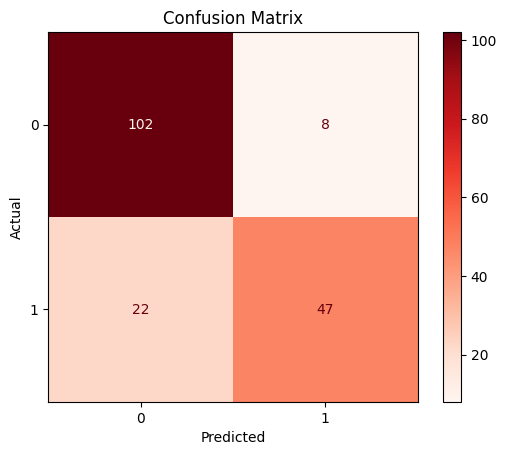

In [250]:
# 混同行列の表示
a.display_confusion_matrix(y_val, x_val_pred)

## 予測値の分布表示

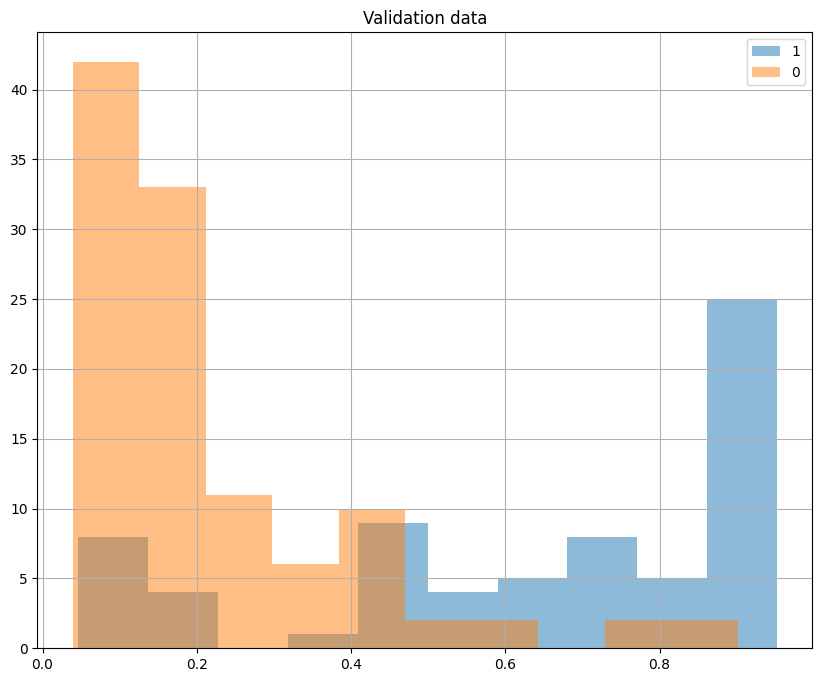

In [251]:
a.display_prediction(y_val, x_val, model)

# テスト

## 学習モデルをテストデータに使用

In [252]:
# テストデータセットの作成
x_test, id_test = a.make_test_dataset()
# 学習モデルによる推論
y_test_pred = model.predict(x_test)

x_test: (418, 4), id_test: (418,)


## 提出用ファイルの作成

In [253]:
a.make_submission_file(y_test_pred, id_test)

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
